# 1. Analysis Data

In [93]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt

In [94]:
from statsmodels.tsa.stattools import adfuller
def draw_ts(timeSeries):
    f = plt.figure(figsize=(10,5), facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
    
# analysis stationarity 
def test_stationarity(timeseries, w=20, title='test_ts'):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=w).mean()
    rolstd = timeseries.rolling(window=w).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test: (ADF test)
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [95]:
# load data file names
working_folder = ".."
data_folder = os.path.join(working_folder, 'data')
format1_files = ['data_format1_201807.h5']#, 'data_format1_201808.h5']
format2_files = ['data_format2_201807.h5']#, 'data_format2_201808.h5']

# for f in os.listdir(data_folder):
#     if len(f) == 22:
#         if 'format1' in f:
#             format1_files.append(f)
#         elif 'format2' in f:
#             format2_files.append(f)

sorted(format1_files)
sorted(format2_files)
print(format1_files)
print(format2_files)

['data_format1_201807.h5']
['data_format2_201807.h5']


In [96]:
cur_datas = pd.DataFrame()
cur_datas_bch = pd.DataFrame()
cur_datas_btc = pd.DataFrame()
opened_files = list()
for f in format1_files:
    f_fp = os.path.join(data_folder, f)
#     print(f_fp)
    f1_data = pd.HDFStore(f_fp)
    opened_files.append(f1_data)
    cur_bch = f1_data['BCH-USD']
    cur_btc = f1_data['BTC-USD']

    if not cur_datas.empty:
        cur_datas = cur_datas.append(cur_bch)
        cur_datas_bch = cur_datas.append(cur_bch)
        cur_datas_btc = cur_datas.append(cur_btc)
    else:
        cur_datas = cur_bch
        cur_datas_bch = cur_bch
        cur_datas_btc = cur_btc

cur_datas_bch = (0.25 * (cur_datas_bch['close'] + cur_datas_bch['open'] + cur_datas_bch['high'] + cur_datas_bch['low']))
cur_datas_btc = (0.25 * (cur_datas_btc['close'] + cur_datas_btc['open'] + cur_datas_btc['high'] + cur_datas_btc['low']))

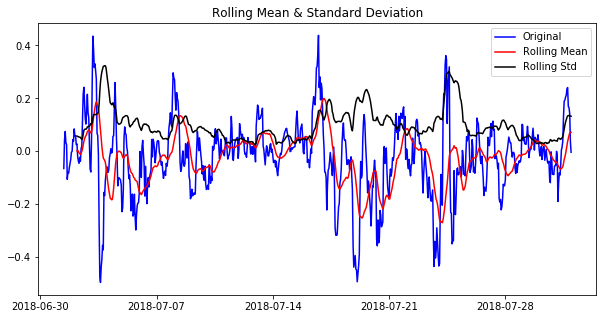

Results of Dickey-Fuller Test:
Test Statistic                  -4.045857
p-value                          0.001189
#Lags Used                      20.000000
Number of Observations Used    713.000000
Critical Value (1%)             -3.439555
Critical Value (5%)             -2.865602
Critical Value (10%)            -2.568933
dtype: float64


time
2018-07-01 10:00:00   -0.065114
2018-07-01 11:00:00    0.042225
2018-07-01 12:00:00    0.074661
2018-07-01 13:00:00    0.031691
2018-07-01 14:00:00    0.025688
Freq: H, dtype: float64

In [106]:
cur_datas_bch = cur_datas_bch.resample('H').mean()
cur_datas_btc = cur_datas_btc.resample('H').mean()
ts = (cur_datas_bch.diff(10) / cur_datas_bch.diff(10).max() - cur_datas_btc.diff(10) / cur_datas_btc.diff(10).max())#.plot(figsize=(15, 10))
# diff to stable
ts_log = np.log(ts)
ts_diff = ts_log.diff(1)
ts_diff.dropna(inplace=True)
# ts_log.dropna(inplace=True)
# test_stationarity(ts_log)
ts.dropna(inplace=True)
test_stationarity(ts)
ts.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C9F9D788D0>,
      dtype=object)

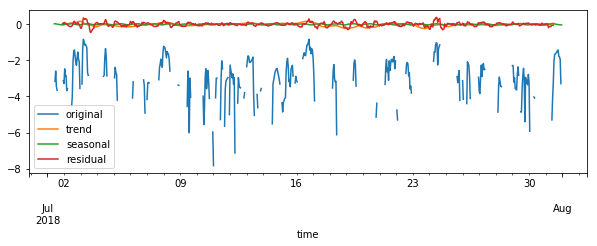

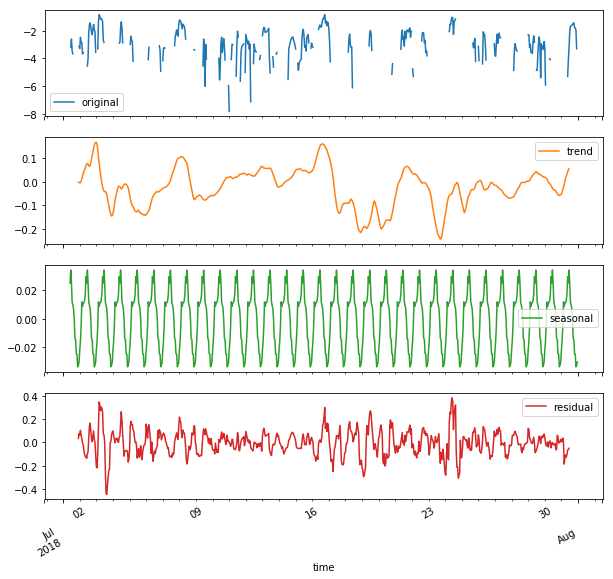

In [107]:
# devide to several parts

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df=pd.DataFrame()
df['original']=ts_log
df['trend']=trend
df['seasonal']=seasonal
df['residual']=residual

df.plot(figsize=(10,3))#, subplots=True)
df.plot(figsize=(10,10), subplots=True)

In [21]:
# close all data file
for f in opened_files:
    f.close()

699840
2018-08-01 00:01:00


<Figure size 432x288 with 0 Axes>

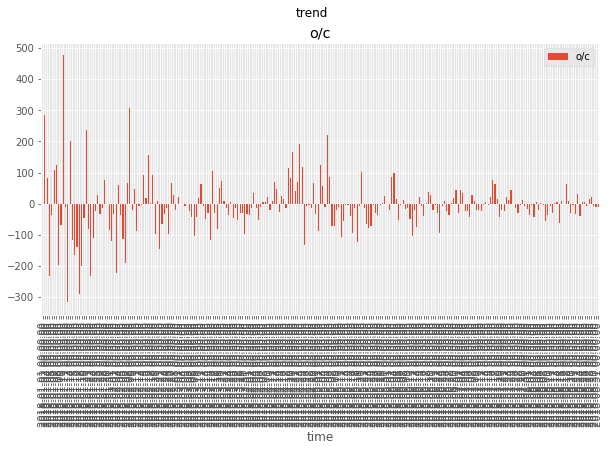

<Figure size 432x288 with 0 Axes>

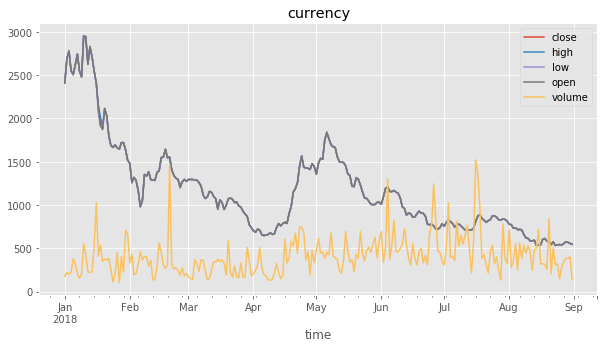

In [201]:
cur_data = cur_datas.copy()

times=cur_data.index
print(len(times))
print(cur_data.iloc[1].name)

cur_data = cur_data.resample('1d').max()
high_series = cur_data['high']
low_series = cur_data['low']
open_series = cur_data['open']
close_series = cur_data['close']
volumn_series = cur_data['volume']


fig = plt.figure()
# (open_series - close_series).plot(title='o/c curve', grid=True)
# cur_data.plot.box()

import matplotlib.style as style
from pandas.plotting import radviz

style.use('ggplot')

plt_data = pd.DataFrame()
plt_data['o/c'] = open_series - open_series.shift(periods=1) #open_series #close_series
# plt_data['x'] = range(len(open_series.index))
# plt_data['o/c'] /= plt_data['o/c'].max()
# plt_data['o/c'][plt_data['o/c']>0] = 1
# plt_data['o/c'][plt_data['o/c']<0] = -1
# plt_data['h/l'] = high_series - low_series
# plt_data['h/l'] /= plt_data['h/l'].max()

# plt_data['o/c'].plot(figsize=(20,10), label='Series')d
# plt_data.plot.scatter(x='x', y='o/c')

plt_data.plot(kind='bar', figsize=(10,5), subplots=True, title='trend', grid=True)
fig.show()

fig_cur = plt.figure()
cur_data.plot(figsize=(10,5), title='currency', grid=True)
fig_cur.show()



In [111]:
# resample half day
cur_data = cur_datas.copy()
cur_data = cur_data.resample('12H').last()
ts = cur_data['close']

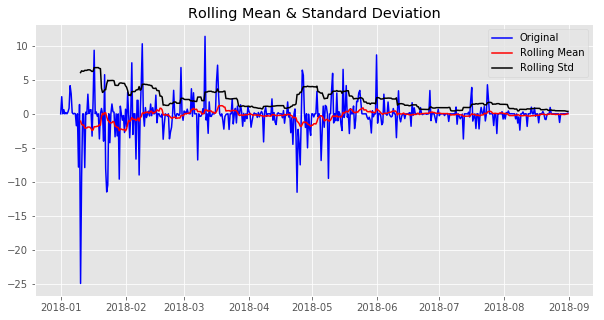

Results of Dickey-Fuller Test:
Test Statistic                -9.651194e+00
p-value                        1.433255e-16
#Lags Used                     4.000000e+00
Number of Observations Used    4.810000e+02
Critical Value (1%)           -3.444018e+00
Critical Value (5%)           -2.867568e+00
Critical Value (10%)          -2.569980e+00
dtype: float64


In [160]:
test_stationarity(cur_data['open'] - cur_data['close'])

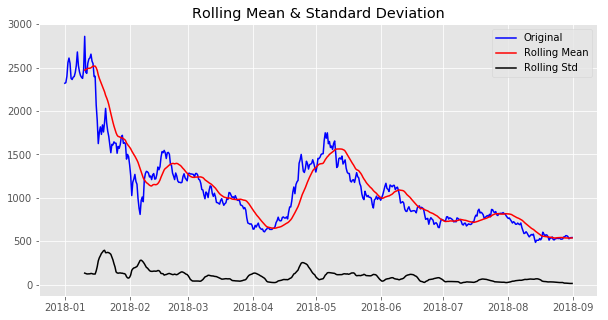

Results of Dickey-Fuller Test:
Test Statistic                  -2.288203
p-value                          0.175801
#Lags Used                       0.000000
Number of Observations Used    485.000000
Critical Value (1%)             -3.443905
Critical Value (5%)             -2.867518
Critical Value (10%)            -2.569954
dtype: float64


In [113]:
test_stationarity(ts, 20, title='bch')

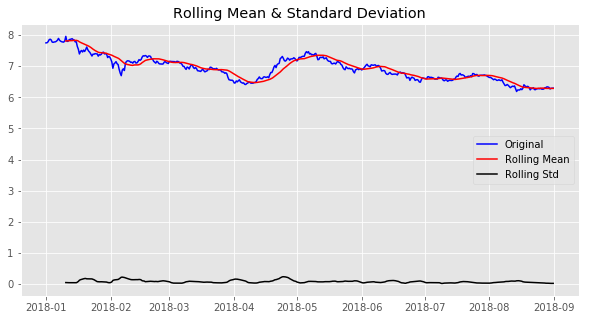

Results of Dickey-Fuller Test:
Test Statistic                  -1.746073
p-value                          0.407544
#Lags Used                       2.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


In [125]:
# diff to stable
ts_log = np.log(ts)
ts_diff = ts_log.diff(1)
ts_diff.dropna(inplace=True)
test_stationarity(ts_log)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2bbc3d30>,
      dtype=object)

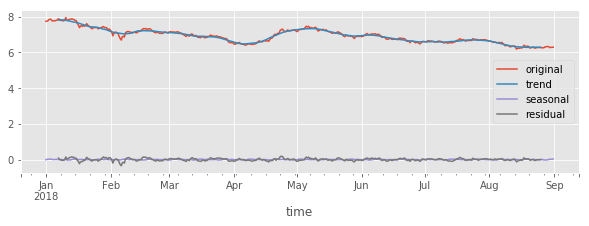

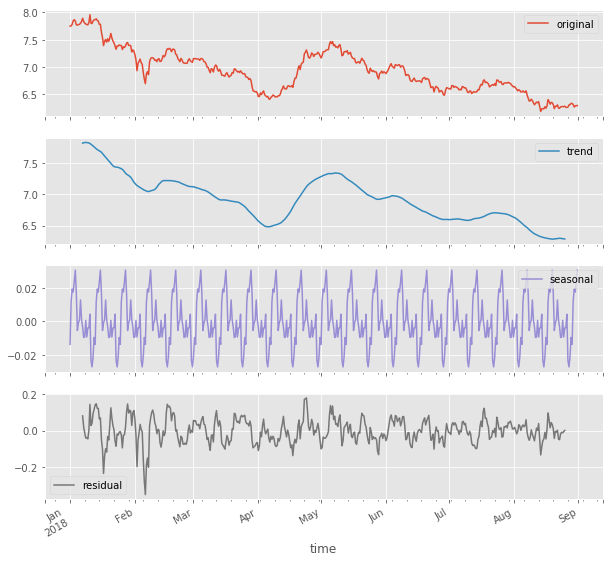

In [154]:
# devide to several parts

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df=pd.DataFrame()
df['original']=ts_log
df['trend']=trend
df['seasonal']=seasonal
df['residual']=residual

df.plot(figsize=(10,3))#, subplots=True)
df.plot(figsize=(10,10), subplots=True)

In [193]:
# model identification for each part
rol_mean = ts_log.rolling(window=20).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -3.496914
p-value                          0.008067
#Lags Used                       3.000000
Number of Observations Used    462.000000
Critical Value (1%)             -3.444584
Critical Value (5%)             -2.867816
Critical Value (10%)            -2.570113
dtype: float64

In [194]:
# Fitting model
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order=(1, 1)) 
result_arma = model.fit(disp=-1, method='css')

In [195]:
# recover the change
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover = predict_ts.add(diff_shift_ts)
# 移动平均还原
rol_sum=ts_log.rolling(window=20).sum()
rol_recover = diff_recover*20 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

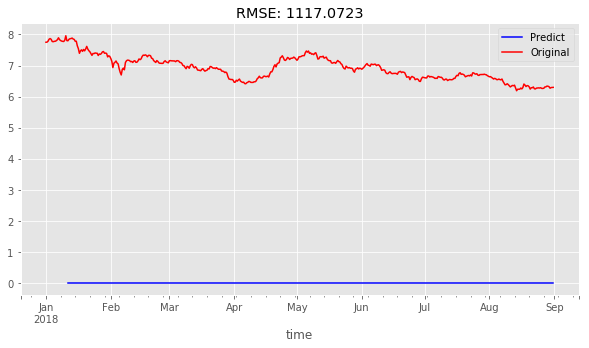

In [196]:
# Evaluation model
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(figsize=(10,5), facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts_log.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

# 2. build the model

In [7]:
from sklearn.externals import joblib
import pandas as pd
import os
import numpy as np

In [8]:
# load data file names
working_folder = "."
data_folder = os.path.join(working_folder, 'data')
format1_files = ['data_format1_201808.h5']
format2_files = ['data_format2_201808.h5']
# load data
cur_datas = pd.DataFrame()
opened_files = list()
for f in format1_files:
    f_fp = os.path.join(data_folder, f)
    f1_data = pd.HDFStore(f_fp)
    opened_files.append(f1_data)
    cur_bch = f1_data['BCH-USD']

    if not cur_datas.empty:
        cur_datas = cur_datas.append(cur_bch)
    else:
        cur_datas = cur_bch

In [ ]:
for f in opened_files:
    f.close()

trend.mean(): 
close    2.064342
open     2.008390
low      2.048413
high     2.038251
dtype: float64

trend.std(): 
close    1.607034
open     1.596930
low      1.608088
high     1.582112
dtype: float64


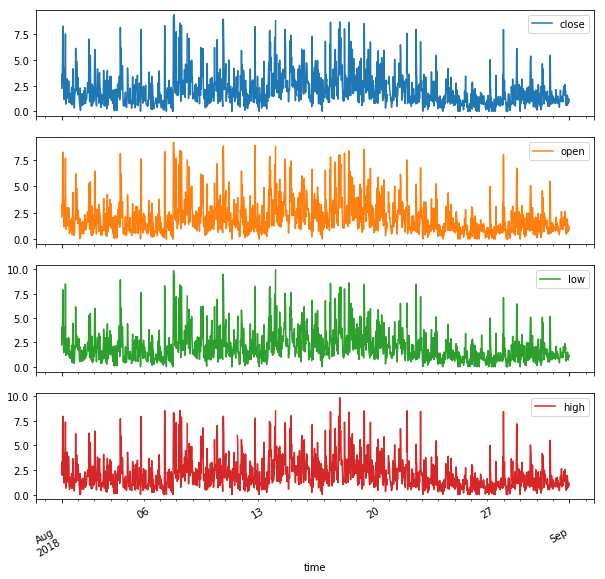

In [5]:
# preprocess data.
# generate the tag for each period(30mins)
avg_range_period = 0
period = '30min'
org_cur_data = cur_datas.copy()[['close', 'open', 'low', 'high']]
resampler = org_cur_data.resample(period)
trend = resampler.pipe(lambda x: 0.5 * (abs(x.max() - x.first()) + abs(x.min() - x.first()))) 
# remove outlier
trend = trend[trend < 10]
trend.plot(figsize=(10,10), subplots=True)

print('trend.mean(): ')
print(trend.mean())
print('\ntrend.std(): ')
print(trend.std())

# periods=len(org_cur_data.index) / 30
# t_index = pd.date_range(start='2018-08-01 00:00:00', end='2018-08-31 23:59:00', freq='30min')

# trend
# print(org_cur_data[30:60])
# print(trend)

# date_time_list=[]
# for t in t_index:
#     date_time_list.append(str(t))
# date_time_list

In [15]:
# load trained model to see what's the prediction of it.
model = joblib.load('model.pkl')
o_c = org_cur_data[['open', 'close']]
prob_pred = model.predict_proba(o_c)
# prob_pred[prob_pred < 0.45] = -1
# prob_pred[prob_pred > 0.55] = 1
?model.predict_proba
prob_pred

array([[0.42819981, 0.57180019],
       [0.42751805, 0.57248195],
       [0.42619074, 0.57380926],
       ...,
       [0.42489641, 0.57510359],
       [0.42465343, 0.57534657],
       [0.42478117, 0.57521883]])